# MFCC 전처리 과정을 통한 Audio MNIST 분류 학습

---

## Import

In [22]:
# cuda gpu 설정 코드
import os
os.add_dll_directory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin')
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# cuda=11.2 cudnn=8.1.0 python=3.8 tensorflow-gpu=2.10.0
# !!!!! 오류 발생 시, 위 코드 삭제 후 실행 !!!!! ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import joblib
import glob
import librosa
from IPython.display import Audio
import IPython.display as ipd

Audio Mnist : <br>
https://www.kaggle.com/datasets/alanchn31/free-spoken-digits

## Load Data

In [23]:
#dir = '/data/free-spoken-digit-dataset-master/recordings/'
dir = 'C:/Users/sihyu/OneDrive - Kumoh/Source_File/VScode/python/DeepLearning/hw08/data/free-spoken-digit-dataset-master/recordings/'
files = sorted(glob.glob(dir + '/*.wav', recursive=True))

print(len(files))
print(files[0])

label = files[0].split('/')[-1].split('_')[0][-1]
print(label)

3000
C:/Users/sihyu/OneDrive - Kumoh/Source_File/VScode/python/DeepLearning/hw08/data/free-spoken-digit-dataset-master/recordings\0_george_0.wav
0


## 데이터 특성 확인

data length: 8956, sampling rate: 22050


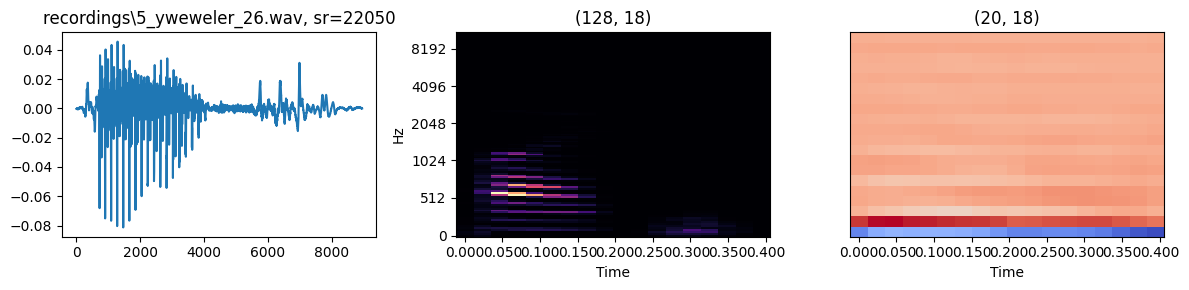

data length: 7434, sampling rate: 22050


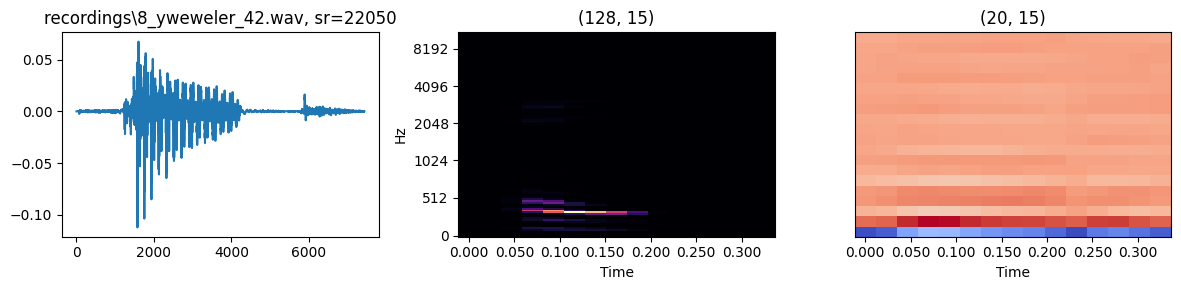

data length: 5273, sampling rate: 22050


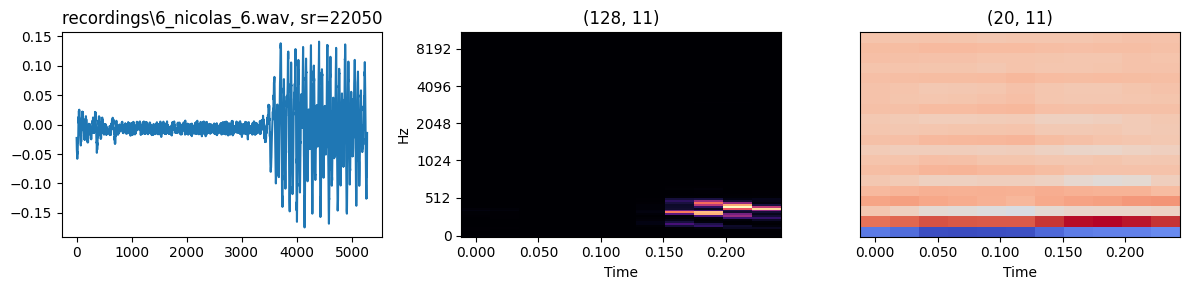

In [24]:
def wav_info(file):
    data, sr = librosa.load(file)
    print(f"data length: {len(data)}, sampling rate: {sr}")
    ipd.display(ipd.Audio(data, rate=sr))

    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(data)
    ax[0].set_title(f"{file.split('/')[-1]}, sr={sr}")

    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(mel, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set_title(f"{mel.shape}")

    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax[2])
    ax[2].set_title(f"{mfcc.shape}")
    plt.tight_layout()
    plt.show()

num = np.random.randint(0,3000,3)
for file in np.array(files)[num]:
    wav_info(file)

## dataframe 생성 및 Trim(오디오 길이 맞춤)

In [25]:
def trim(file):
    dataset = []
    data, sr = librosa.load(file)

    data, _ = librosa.effects.trim(data, top_db=10) #top_db: 임계값(데시벨)
    data = librosa.util.fix_length(data, size=10000) #10000으로 길이 맞추기

    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    label = file.split('/')[-1].split('_')[0][-1]
    dataset.append([mel, mfcc, label])

    return dataset

dataset = joblib.Parallel(n_jobs=-1)(joblib.delayed(trim)(file) for file in files)
df = pd.DataFrame(np.array(dataset, dtype=object).squeeze(), columns=['mel','mfcc','label'])

x_mel = np.array(df['mel'].tolist())
x_mfcc = np.array(df['mfcc'].tolist())
y = np.array(df['label'].tolist())
y = y.astype(int)
print(y)

print(x_mel.shape, x_mfcc.shape, y.shape)

[0 0 0 ... 9 9 9]
(3000, 128, 20) (3000, 20, 20) (3000,)


## train test split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_mfcc, y, test_size=0.2, stratify=y, shuffle=True, random_state=2023)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train[0].shape)
print(y_train)


(2400, 20, 20) (600, 20, 20) (2400,) (600,)
(20, 20)
[1 1 8 ... 4 2 0]


## Model 정의

In [27]:
inputs = keras.Input(shape=(20, 20))
x = layers.Conv1D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 20)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 32)            1952      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 7, 64)             6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 192)               0   

                                                                 
 dense_4 (Dense)             (None, 128)               24704     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 34,154
Trainable params: 34,154
Non-trainable params: 0
_________________________________________________________________


In [28]:
#checkpoint = keras.callbacks.ModelCheckpoint(filepath='model/hw08.hdf5', monitor='loss', save_best_only=True, verbose=0)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=16)

Epoch 1/50
150/150 [==============================] - 1s 6ms/step - loss: 3.9672 - accuracy: 0.6092 - val_loss: 0.5668 - val_accuracy: 0.8333
Epoch 2/50
150/150 [==============================] - 1s 4ms/step - loss: 0.4552 - accuracy: 0.8763 - val_loss: 0.3139 - val_accuracy: 0.9050
Epoch 3/50
150/150 [==============================] - 1s 4ms/step - loss: 0.2608 - accuracy: 0.9221 - val_loss: 0.3464 - val_accuracy: 0.9083
Epoch 4/50
150/150 [==============================] - 1s 4ms/step - loss: 0.1873 - accuracy: 0.9396 - val_loss: 0.2806 - val_accuracy: 0.9200
Epoch 5/50
150/150 [==============================] - 1s 4ms/step - loss: 0.1323 - accuracy: 0.9583 - val_loss: 0.2003 - val_accuracy: 0.9433
Epoch 6/50
150/150 [==============================] - 1s 4ms/step - loss: 0.0928 - accuracy: 0.9712 - val_loss: 0.2632 - val_accuracy: 0.9233
Epoch 7/50
150/150 [==============================] - 1s 4ms/step - loss: 0.1162 - accuracy: 0.9583 - val_loss: 0.2179 - val_accuracy: 0.9300
Epoch 

In [29]:
print(min(history.history["loss"]))
print(max(history.history["accuracy"]))
print(min(history.history["val_loss"]))
print(max(history.history["val_accuracy"]))

0.00037968624383211136
1.0
0.12540264427661896
0.9766666889190674


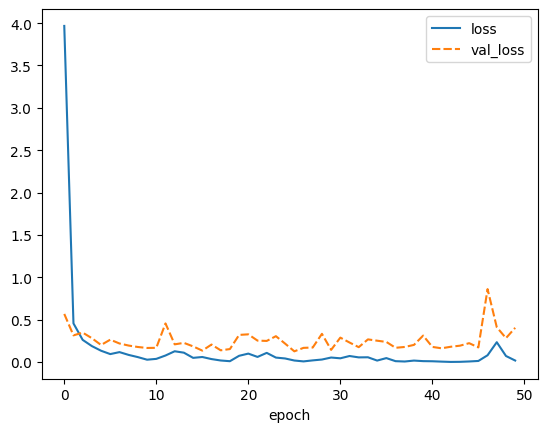

In [30]:
df_result = pd.DataFrame(history.history)
sns.lineplot(df_result[["loss", "val_loss"]])
plt.xlabel("epoch")
plt.show()

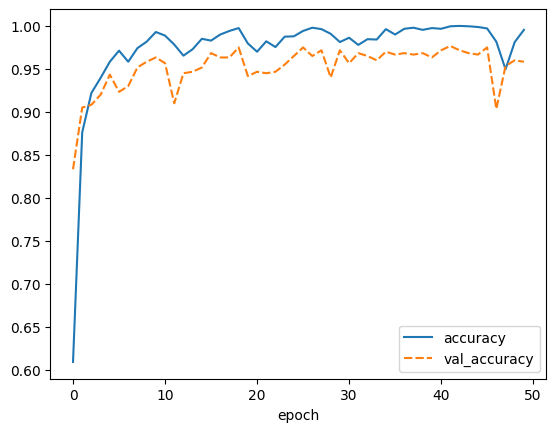

In [31]:
sns.lineplot(df_result[["accuracy", "val_accuracy"]])
plt.xlabel("epoch")
plt.show()